In [1]:
from PIL import Image, ImageOps, ImageChops
import numpy as np
import os
from scipy.optimize import minimize 
from scipy import ndimage
import glob

def findfiles():
    """
    PURPOSE
    Goes through the current working directory within the Jupyter Notebook directory to find ch00/blue, ch01/red, 
    and ch02/green image files.

    REQUIRED INPUTS
    N/A
    

    OPTIONAL INPUTS
    N/A

    OUTPUTS
    blue_files = file path for the ch00/blue images
    red_files = file path for the ch01/red images
    green_files = file path for the ch02/green images

    
    written by Jess Labossiere October 2023
    """
    # Gets the current working directory
    cwd = os.getcwd()
    print(cwd)
    blue_files = glob.glob("*ch00*.tif")
    red_files = glob.glob("*ch02*.tif")
    green_files = glob.glob("*ch01*.tif")
    if not blue_files or not red_files or not green_files:
        raise FileNotFoundError("No TIFF files found matching the specified patterns.")
    
    return blue_files, red_files, green_files


def imtolist(blue_files, red_files, green_files):
    """
    PURPOSE
    Opens the color images into a list. Then, creates numpy arrays out of the tif images. 
    Finally, creates arrays of the size of the image arrays containing only zeros.

    REQUIRED INPUTS
    blue_files = file path for the ch00/blue images
    red_files = file path for the ch01/red images
    green_files = file path for the ch02/green images


    OPTIONAL INPUTS
    N/A

    OUTPUTS
    blue_img = ch001/blue image
    red_img = ch001/red image
    green_img = ch002/green image
    blue_array = numpy array containing the blue tif images
    red_array = numpy array containing the red tif images
    green_array = numpy array containing the green tif images
    blue_sub = numpy array with the size of the blue image array containing only zeros
    red_sub = numpy array with the size of the red image array containing only zeros
    green_sub = numpy array with the size of the green image array containing only zeros

    written by Jess Labossiere October 2023
    """
    blue_img = Image.open(blue_files[0])
    red_img = Image.open(red_files[0])
    green_img = Image.open(green_files[0])

    blue_array = np.array(blue_img)
    red_array = np.array(red_img)
    green_array = np.array(green_img)

    blue_sub = np.zeros_like(blue_array)
    red_sub = np.zeros_like(red_array)
    green_sub = np.zeros_like(green_array)
    
    return blue_img, red_img, green_img, blue_array, red_array, green_array, blue_sub, red_sub, green_sub


def filter_nan_gaussian_conserving(arr, sigma):
    """Apply a gaussian filter to an array with nans.

    Intensity is only shifted between not-nan pixels and is hence conserved.
    The intensity redistribution with respect to each single point
    is done by the weights of available pixels according
    to a gaussian distribution.
    All nans in arr, stay nans in gauss.
    """
    
    nan_msk = np.isnan(arr)
    loss = np.zeros(arr.shape)
    loss[nan_msk] = 1
    loss = ndimage.gaussian_filter(
            loss, sigma=sigma, mode='constant', cval=1)

    gauss = arr.astype(float)  # Convert to float type
    gauss[nan_msk] = 0
    gauss = ndimage.gaussian_filter(
            gauss, sigma=sigma, mode='constant', cval=0)
    gauss[nan_msk] = np.nan

    gauss += loss * arr

    return gauss


def mask_and_optimize(blue, red, green):
    """
    Apply masking and optimization to subtract the scaled red channel from the green channel.

    This function applies a mask to the red channel and optimizes a scaling factor 'B' such that 
    when the scaled red channel is subtracted from the green channel, the residuals are minimized.

    Parameters:
    - blue (numpy.ndarray): Blue channel image array.
    - red (numpy.ndarray): Red channel image array.
    - green (numpy.ndarray): Green channel image array.

    Returns:
    - numpy.ndarray: Image array resulting from subtracting the scaled red channel from the green channel.
    """
    blue = np.array(blue)
    red = np.array(red)
    green = np.array(green)
    
    # Convert NaN values to 0
    #blue = np.nan_to_num(blue)
    #red = np.nan_to_num(red)
    #green = np.nan_to_num(green)
    mask = mask_em(blue, red, green)
    
    # Extract a single channel from the mask array
    mask_channel = mask[:, :, 0]
    
    # Initial guess for the parameter B
    initial_guess = [2.0]
    # Bounds for B
    bounds = ((0, None),)
    thresh = 100
    # Optimize the parameters
    result = minimize(residuals_squared, initial_guess, args=(blue, red, green, mask, thresh), bounds=bounds)
    B_opt = result.x[0]
    
    masked_red = red * mask
    masked_green= green* mask
    sub_green = green[:,:,1] - ((B_opt*masked_red)[:,:,0])
    red_opt= (B_opt*masked_red)
    
    return masked_red, masked_green, sub_green, red_opt

def mask_em(blue, red, green):
    """
    Create a mask based on the red channel of an image.

    This function generates a binary mask where pixels are set to 1 if the corresponding pixel
    in the red channel is non-zero and 0 otherwise. NaN values are assigned to pixels where the 
    red channel is zero.

    Parameters:
    - blue (numpy.ndarray): Blue channel image array.
    - red (numpy.ndarray): Red channel image array.
    - green (numpy.ndarray): Green channel image array.

    Returns:
    - numpy.ndarray: Binary mask array with the same shape as the input images."""
    # Creates a mask
    mask = np.zeros_like(red,dtype=np.float)
    for i in range(512):
        for j in range (512):
            if red[i, j, 0] > 0:
                mask[i, j, :] = 1
            else: 
                mask[i, j, :] = np.nan
    return mask


def residuals_squared(params, blue, red, green, mask, thresh):
    """
    Calculate the mean of squared residuals after applying a given mask and threshold.

    Parameters:
    - params (list): List of parameters. Expected to contain a single value representing the scaling factor 'B'.
    - blue (numpy.ndarray): Blue channel image array.
    - red (numpy.ndarray): Red channel image array.
    - green (numpy.ndarray): Green channel image array.
    - mask (numpy.ndarray): Binary mask array with the same shape as the input images.
    - thresh (float): Threshold value for residual squared to zero out high residuals.

    Returns:
    - float: Mean of squared residuals after thresholding.
    """
    B = params[0]

    # Mask the arrays where mask is NaN
    masked_red = np.where(np.isnan(mask), np.nan, red)
    masked_green = np.where(np.isnan(mask), np.nan, green)

    # Apply mask and calculate residuals squared where mask is not NaN
    masked_red = masked_red * mask
    masked_green = masked_green * mask
    imresid = masked_green - B * masked_red
    resids = np.square(imresid)

    # Apply thresholding
    resids[resids > thresh] = 0
    
    # Calculate mean of squared residuals
    mean_resids = np.nanmean(resids)
    
    return mean_resids


def maskandsave(blue_img, red_img, green_img, sub00, sub02):
    """
    PURPOSE
    Masks the green image. Then, saves three images: the processed green image, the processed blue image, 
    and a combined processed green and blue image.

    REQUIRED INPUTS
    blue_img = ch001/blue image
    red_img = ch001/red image
    green_img = ch002/green image
    sub00 = blue processed image
    sub02 = green processed image

    OPTIONAL INPUTS
    N/A

    OUTPUTS
    N/A

    written by Jess Labossiere October 2023
    """
    path = os.getcwd()
    New_Folder = "Analyzed_Images"
    
    # Create the directory if it doesn't exist
    if not os.path.exists(os.path.join(path, New_Folder)):
        os.makedirs(os.path.join(path, New_Folder))
    
    if sub02 is not None and sub00 is not None:
        mask = np.zeros((512, 512, 3))
        mask[:, :, 1] = sub00[:, :, 2] 
        sub02[mask == 0] = 0
        combined = sub00 + sub02
        comp = Image.fromarray((combined).astype(np.uint8))
        comp.save(os.path.join(path, New_Folder, f"{blue_img.split('_')[0]}comp.tif"))
    
    if sub00 is not None:
        pro00 = Image.fromarray((sub00).astype(np.uint8))
        pro00.save(os.path.join(path, New_Folder, f"{blue_img.split('_')[0]}pro00.tif"))
    
    if sub02 is not None:
        pro02 = Image.fromarray((sub02).astype(np.uint8))
        pro02.save(os.path.join(path, New_Folder, f"{blue_img.split('_')[0]}pro02.tif"))

# Main Function
def main():
    blue_files, red_files, green_files = findfiles()
    blue_img, red_img, green_img, blue_array, red_array, green_array, blue_sub, red_sub, green_sub = imtolist(blue_files, red_files, green_files)
    smooth = filter_nan_gaussian_conserving(red_array, 50)
    masked_red, masked_green, sub_green, red_opt = mask_and_optimize(blue_array, red_array, green_array)
    maskandsave(blue_files[0], red_files[0], green_files[0], blue_sub, green_sub)
    plot_images(blue_img, red_img, green_img, masked_red, masked_green, sub_green,smooth, red_opt)

In [4]:
import matplotlib.pyplot as plt

def plot_images(blue_img, red_img, green_img, mask, masked_green, sub_green, smooth, red_opt):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    # Plot original images
    axes[0, 0].imshow(blue_img, cmap='Blues')
    axes[0, 0].set_title('Blue Channel')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(red_img, cmap='Reds')
    axes[0, 1].set_title('Red Channel')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(green_img, cmap='Greens')
    axes[0, 2].set_title('Green Channel')
    axes[0, 2].axis('off')
    
    # Plot masks
    axes[1, 1].imshow(mask, cmap='binary')
    axes[1, 1].set_title('Masked_red')
    axes[1, 1].axis('off')
    
    axes[1, 0].imshow(masked_green, cmap='Greens')
    axes[1, 0].set_title('Masked Green Channel')
    axes[1, 0].axis('off')
    
    axes[1, 2].imshow(smooth, cmap='Greens')
    axes[1, 2].set_title('Smooth red')
    axes[1, 2].axis('off')
    
    # Plot subtracted images
    axes[2, 0].imshow(sub_green, cmap='Greens')
    axes[2, 0].set_title('Subtracted Green Channel')
    axes[2, 0].axis('off')
    
    axes[2, 1].imshow(red_opt, cmap='Reds')
    axes[2, 1].set_title('Optimal B * Red')
    axes[2, 1].axis('off')
    
    # Hide empty subplot
    axes[2, 1].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

/Users/kinseycronin/Desktop/research code


/var/folders/kr/9jnkrnhs4tx7x31l9f0ckr_c0000gn/T/ipykernel_33952/4068904707.py:171: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(red,dtype=np.float)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


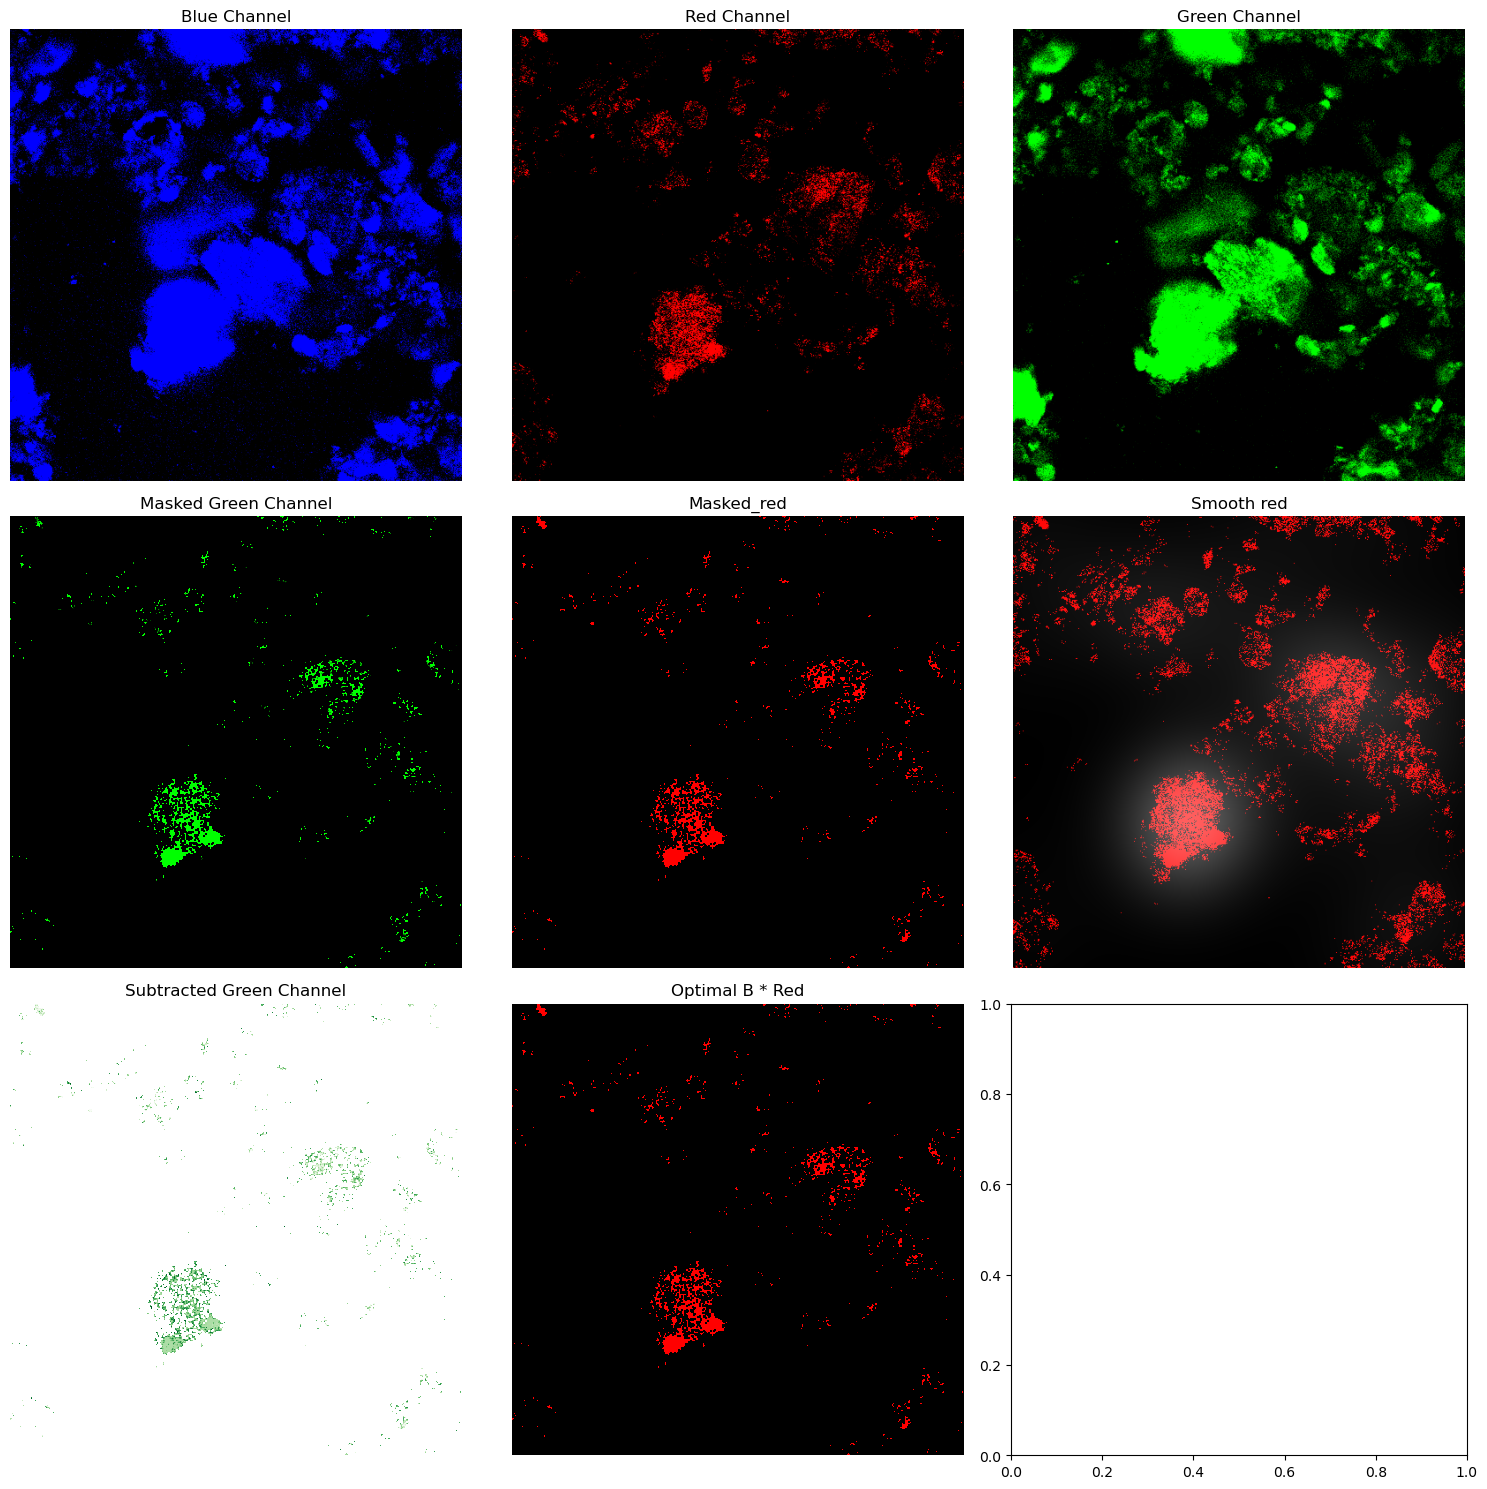

In [5]:
main()